## Data Set Information:

This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from north east of Andhra Pradesh, India. Selector is a class label used to divide into groups(liver patient or not). This data set contains 441 male patient records and 142 female patient records.

Any patient whose age exceeded 89 is listed as being of age "90".


### Attribute Information:

1. Age Age of the patient
2. Gender Gender of the patient
3. TB Total Bilirubin
4. DB Direct Bilirubin
5. Alkphos Alkaline Phosphotase
6. Sgpt Alamine Aminotransferase
7. Sgot Aspartate Aminotransferase
8. TP Total Protiens
9. ALB Albumin
10. A/G Ratio Albumin and Globulin Ratio
11. is_patient field used to split the data into two sets (labeled by the experts)

### Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smo
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,precision_score,recall_score,cohen_kappa_score,f1_score,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [2]:
df=pd.read_csv('liver.csv')
df.head()

,age,gender,tot_bilirubin,direct_bilirubin,tot_proteins,albumin,ag_ratio,sgpt,sgot,alkphos,is_patient
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               583 non-null    int64  
 1   gender            583 non-null    object 
 2   tot_bilirubin     583 non-null    float64
 3   direct_bilirubin  583 non-null    float64
 4   tot_proteins      583 non-null    int64  
 5   albumin           583 non-null    int64  
 6   ag_ratio          583 non-null    int64  
 7   sgpt              583 non-null    float64
 8   sgot              583 non-null    float64
 9   alkphos           579 non-null    float64
 10  is_patient        583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


### Statistical summary

In [4]:
df.describe()

,age,tot_bilirubin,direct_bilirubin,tot_proteins,albumin,ag_ratio,sgpt,sgot,alkphos,is_patient
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


### Value count of categorical columns

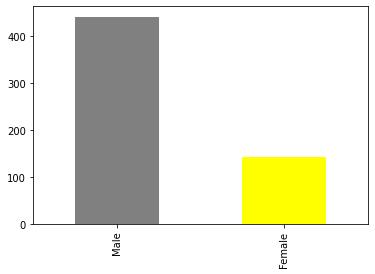

In [5]:
df_cat=df.select_dtypes(include='object')
for i in df_cat:
    df[i].value_counts().plot(kind='bar',color=['grey','yellow'])

### Examining for missing values

In [6]:
df.isna().sum()

age                 0
gender              0
tot_bilirubin       0
direct_bilirubin    0
tot_proteins        0
albumin             0
ag_ratio            0
sgpt                0
sgot                0
alkphos             4
is_patient          0
dtype: int64

In [7]:
df=df.dropna()

In [8]:
df=df.reset_index(drop=True)

For the purpose of further analysis, the missing values have been removed.

#### The average age of people with liver disease differed depending on their gender.

<AxesSubplot:xlabel='gender', ylabel='age'>

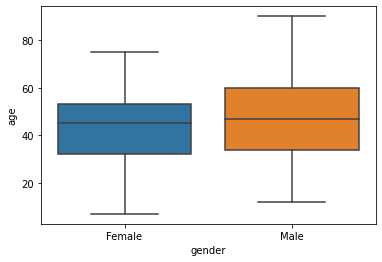

In [9]:
sns.boxplot(y='age',x='gender',data=df[df['is_patient']==1])

### Data Corelation matrix

<AxesSubplot:>

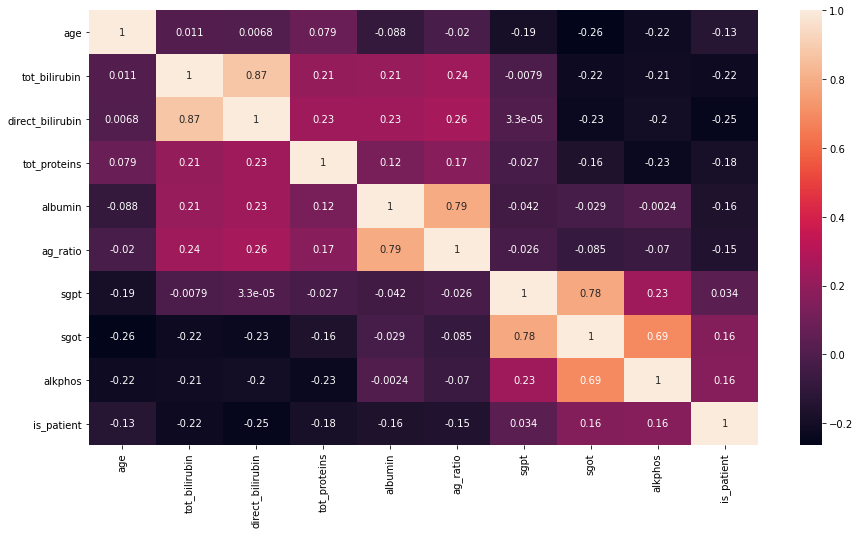

In [10]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),annot=True)

The dependent features and the independent features have a weak correlation.

### Boxplot

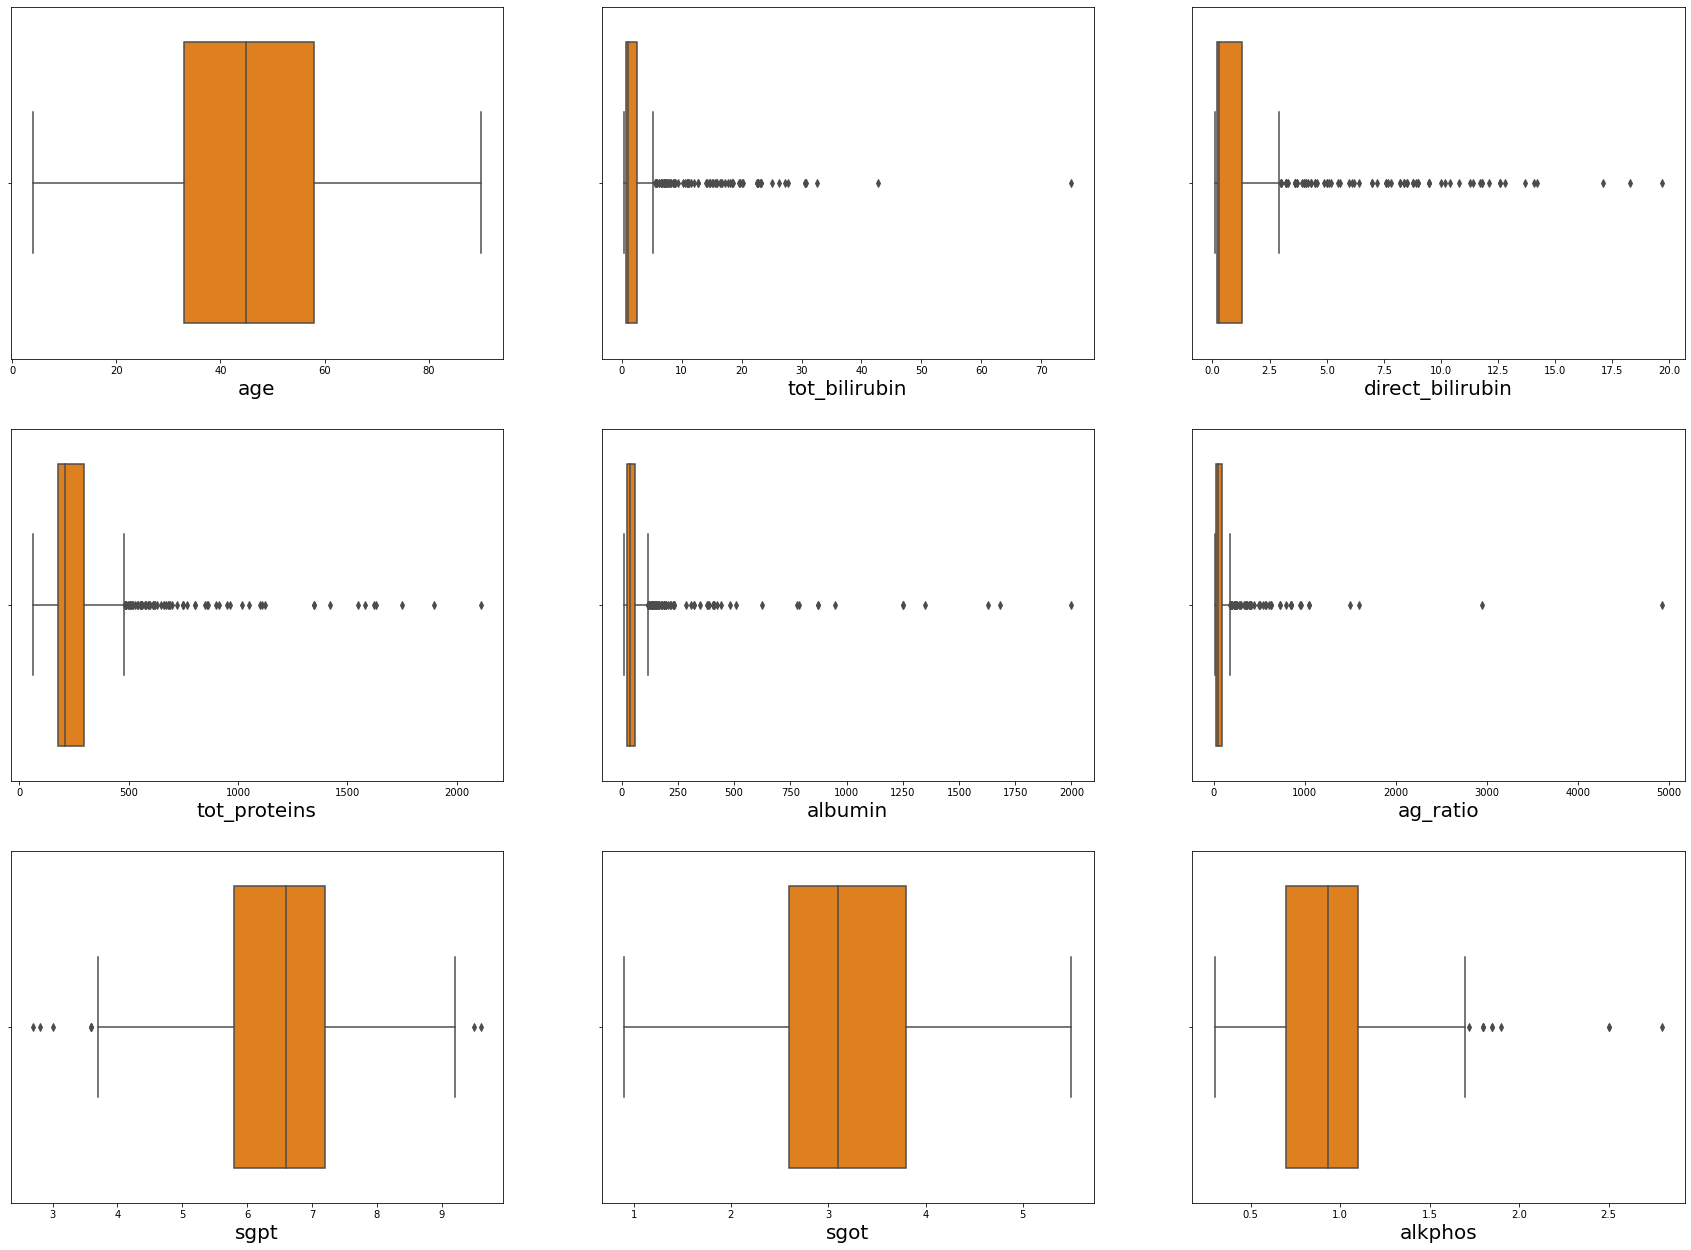

In [11]:
df_num=df.select_dtypes(exclude='object')
fig, ax = plt.subplots(3,3 , figsize=(30, 22))

for variable, subplot in zip(df_num.columns, ax.flatten()):
    z = sns.boxplot(x = df_num[variable], orient = "v",palette="autumn", whis = 1.5 , ax = subplot) # plot the boxplot
    z.set_xlabel(variable, fontsize = 20)


We can't remove some extreme outliers in some of the features unless there's a compelling reason to do so.

### Can the outliers be removed?

Here, 40 extreme outliers from each feature are analysed to see if the higher values indicate disease.

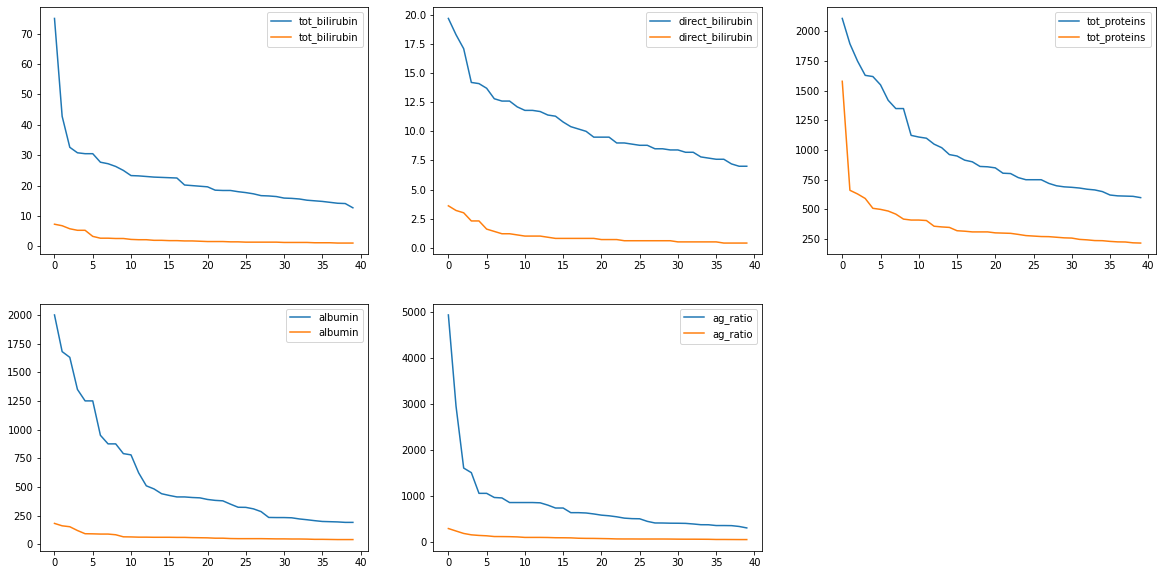

In [12]:
plt.figure(figsize=(20,10))
for j,i in enumerate(['tot_bilirubin', 'direct_bilirubin', 'tot_proteins','albumin', 'ag_ratio']):
    plt.subplot(2,3,j+1)
    df[df['is_patient']==1][i].sort_values(ascending=False)[:40].reset_index(drop=True).plot()
    df[df['is_patient']==2][i].sort_values(ascending=False)[:40].reset_index(drop=True).plot()
    plt.legend()

Outliers should not be removed because high values clearly indicate liver disease.

### Label Encoding of gender column

In [13]:
label_encoder=LabelEncoder()
df['gender']=label_encoder.fit_transform(df['gender'])

### Bivariate distributions

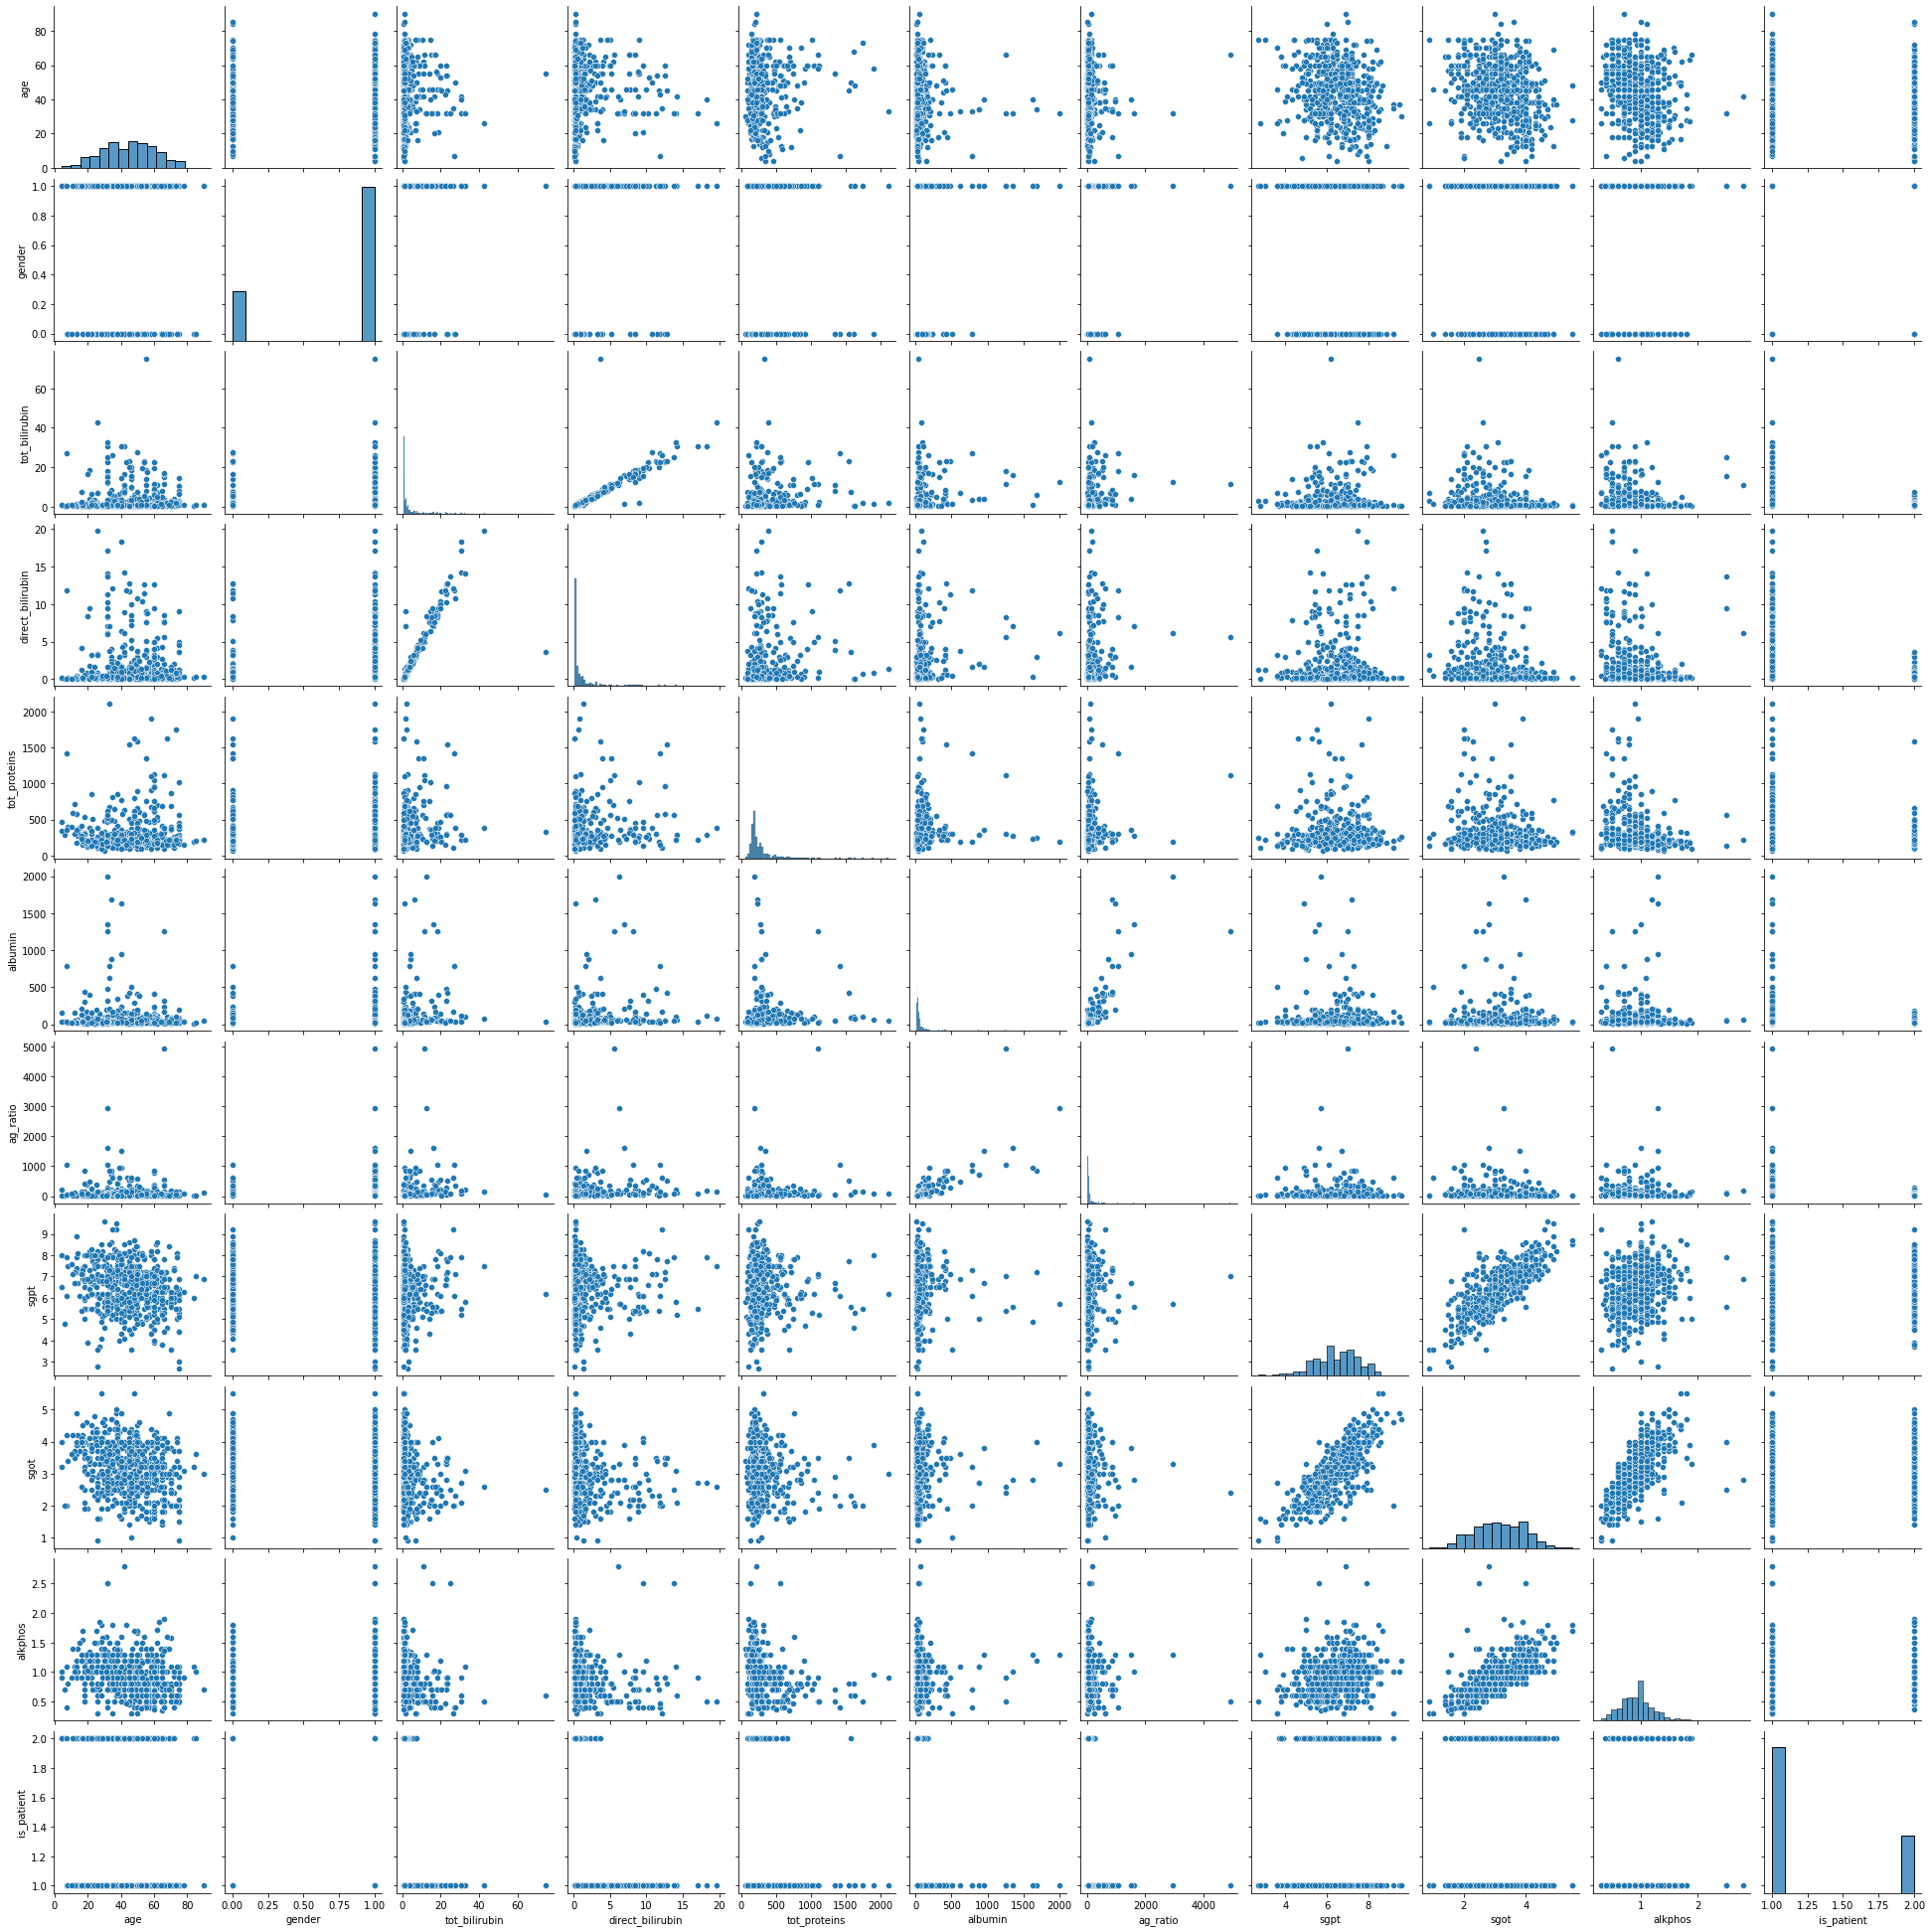

In [14]:
sns.pairplot(df)

In [15]:
df_features=df.drop('is_patient',axis=1)
df_target=df['is_patient']

### Class count of target Variables

In [16]:
df['is_patient'].value_counts()

1    414
2    165
Name: is_patient, dtype: int64

#### Replacing class 2 with 0

In [17]:
df['is_patient'].replace({2:0},inplace=True)

### Balancing the target class using upsampling method

In [18]:
sm=SMOTE(random_state=42)
df_features,df_target=sm.fit_resample(df_features,df_target)
df_target.value_counts()

0    414
1    414
Name: is_patient, dtype: int64

In [19]:
X=df_features
y=df_target

### Scaling the data (Standard Scaler)

In [20]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
X=pd.DataFrame(scalar.fit_transform(X),columns=X.columns)

### Splitting the data into train-test with test-size=0.2

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Base Model

In [22]:
lg=LogisticRegression()
lg.fit(X_train,y_train)
y_train_pred=lg.predict(X_train)
y_test_pred=lg.predict(X_test)
print(classification_report(y_train,y_train_pred,target_names=['Healthy ','Liver Disease']))
print("-----------------------------------------------------------")
print(classification_report(y_test,y_test_pred,target_names=['Healthy ','Liver Disease']))

               precision    recall  f1-score   support

     Healthy        0.69      0.82      0.75       331
Liver Disease       0.78      0.64      0.70       331

     accuracy                           0.73       662
    macro avg       0.74      0.73      0.73       662
 weighted avg       0.74      0.73      0.73       662

-----------------------------------------------------------
               precision    recall  f1-score   support

     Healthy        0.64      0.82      0.72        83
Liver Disease       0.75      0.54      0.63        83

     accuracy                           0.68       166
    macro avg       0.70      0.68      0.67       166
 weighted avg       0.70      0.68      0.67       166



* Because this is a liver disease, it must be diagnosed as soon as possible and treatment should begin at the earliest
* The goal is to keep False Negative as low as possible in order to ensure that the patient with liver disease is not overlooked.
* Recall is very low in our model, indicating that False Negative is high; to increase recall, the threshold has been reduced to 0.4 and the classification report has been printed again.

### Model Performace with cut-off threshold 0.4

In [23]:
lg=LogisticRegression()
lg.fit(X_train,y_train)
y_train_pred=[1 if i>0.4 else 0 for i in lg.predict_proba(X_train)[:,1]]
y_test_pred=[1 if i>0.4 else 0 for i in lg.predict_proba(X_test)[:,1]]
print(classification_report(y_train,y_train_pred))
print("-----------------------------------------------------------")
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.65      0.70       331
           1       0.69      0.79      0.74       331

    accuracy                           0.72       662
   macro avg       0.72      0.72      0.72       662
weighted avg       0.72      0.72      0.72       662

-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.57      0.59        83
           1       0.60      0.64      0.62        83

    accuracy                           0.60       166
   macro avg       0.60      0.60      0.60       166
weighted avg       0.60      0.60      0.60       166



* There is a 10% improvement in recall after setting the threshold to 0.4, indicating a better model.
* Because there is a significant difference in train and test recall, the model is overfitted.

### Random Forest model (Best Model)

In [24]:
rf=RandomForestClassifier(max_depth=3)
rf.fit(X_train,y_train)
y_train_pred=[1 if i>0.4 else 0 for i in rf.predict_proba(X_train)[:,1]]
y_test_pred=[1 if i>0.4 else 0 for i in rf.predict_proba(X_test)[:,1]]
print(classification_report(y_train,y_train_pred))
print("-----------------------------------------------------------")
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       331
           1       0.76      0.78      0.77       331

    accuracy                           0.76       662
   macro avg       0.76      0.76      0.76       662
weighted avg       0.76      0.76      0.76       662

-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        83
           1       0.73      0.73      0.73        83

    accuracy                           0.73       166
   macro avg       0.73      0.73      0.73       166
weighted avg       0.73      0.73      0.73       166



Random forest with maximum tree depth 3 outperformed logistic regression, with train and rest recall nearly equal, indicating that the model is not overfitting.

### Important features that contribute to liver disease

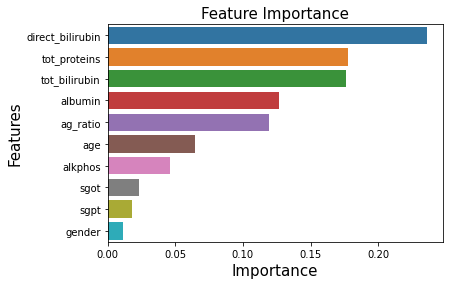

In [25]:
important_features=pd.DataFrame({'Features':X_train.columns,'Importance':rf.feature_importances_})
important_features = important_features.sort_values('Importance', ascending = False)
sns.barplot(x = 'Importance', y = 'Features', data = important_features)
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.show()